In [1]:
!pwd

/home/kei/Desktop/CausalKinetiX-Python/dev


In [2]:
import numbers
import numpy as np
from matplotlib import pyplot as plt
import os
os.chdir("/home/kei/Desktop/CausalKinetiX-Python/")
from CausalKinetiX import CausalKinetiX
from CausalKinetiX.CausalKinetiX_modelranking import CausalKinetiX_modelranking
from CausalKinetiX.constrained_smoothspline import constrained_smoothspline
from CausalKinetiX.generate_data_targetmodel import generate_data_targetmodel

In [3]:
!ls

CausalKinetiX  dev  LICENCE  README.md	setup.py


In [4]:
!ls CausalKinetiX

BSbasis.py		       constrained_smoothspline.py   __pycache__
CausalKinetiX_modelranking.py  generate_data_targetmodel.py  utils.py
CausalKinetiX.py	       __init__.py


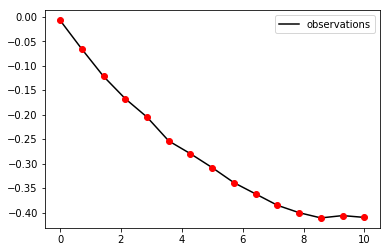

In [5]:
simulation_obj = generate_data_targetmodel(env=np.array(list(range(5))*3),
                                            L=15,
                                            d=5)
D = simulation_obj["simulated_data"]
fulldata = simulation_obj["true_model"]
time = simulation_obj["time"]
env = simulation_obj["env"]
target = simulation_obj["target"]
# plot the observation of target variable in environment 0
plt.plot(time, D[0,-len(time):], '-',c="black")
plt.plot(time, D[0,-len(time):], 'o',c="red")
plt.legend(["observations"])


In [6]:
CausalKinetiX(D = D, times = time, env=env, target = target)

{'models': [[[0], [1], [2]],
  [[0], [1], [3]],
  [[0], [1], [4]],
  [[0], [2], [3]],
  [[0], [2], [4]],
  [[0], [3], [4]],
  [[1], [2], [3]],
  [[1], [2], [4]],
  [[1], [3], [4]],
  [[2], [3], [4]]],
 'model_scores': array([6.33727755e+12, 3.87827042e+12, 4.57678247e+12, 9.16798511e+15,
        1.42206988e+15, 9.28768701e+14, 8.27806609e+14, 2.03112652e+15,
        1.29360556e+15, 5.50889240e+14]),
 'variable_scores': array([0.        , 0.        , 0.66666667, 0.66666667, 0.66666667]),
 'ranking': array([0, 1, 2, 3, 4])}

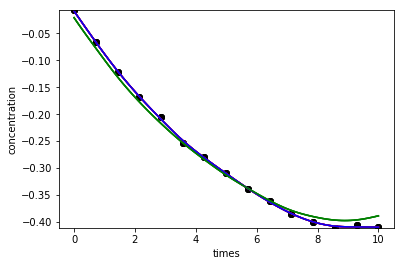

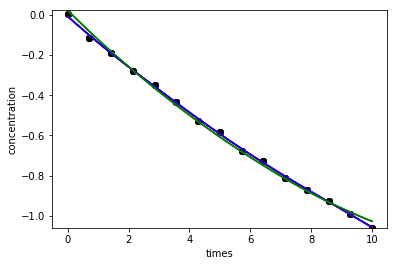

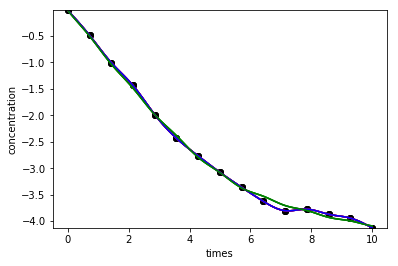

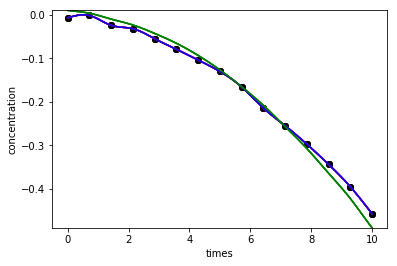

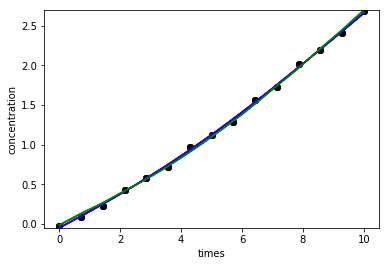

array([2.15960239e+13])

In [7]:
CausalKinetiX_modelranking(D, time, env, target, [[[0],[1],[2]]], include_vars=None, show_plot=True, integrated_model=False)#, regression_class='random_forest')

In [8]:
fit = constrained_smoothspline(D[1,60:],
                                          time,
                                          2,
                                          constraint="none",
                                          times_new=time,
                                          num_folds=2,
                                          lambd="optim")

In [9]:
fit.keys()

dict_keys(['smooth_vals', 'residuals', 'smooth_vals_new', 'smooth_deriv', 'pen_par'])

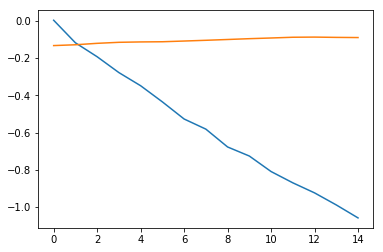

In [10]:
plt.plot(D[1,60:])
plt.plot(fit["smooth_deriv"])
